In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

%matplotlib inline

In [2]:
def pure(*args, **kwargs):
    return 1

def damped(*args, **kwargs):
    return kwargs['alpha']

def armijo_step(x, h, **kwargs):
    f = kwargs["f"]
    gradf = kwargs["gradf"]
    gradient = gradf(x)
    alpha = 1
    x_next = x + alpha * h
    while f(x_next) > f(x) + 0.3 * alpha * gradient.dot(x_next - x):
        alpha *= 0.6
        x_next = x + alpha * h
    return alpha

def func_conv(x, **kwargs):
    return np.linalg.norm(kwargs['f'](x) - kwargs['f_true'](x))

def grad_conv(x, **kwargs):
    return np.linalg.norm(kwargs['gradf'](x))


In [6]:
def f_rosenbrock(x):
    x1, x2 = x
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2

def gradf_rosenbrock(x):
    x1, x2 = x
    return np.array([400 * x1 * (x1**2 - x2) + 2 * (x1 - 1), 200 * (x2 - x1**2)])

def hessf_rosenbrock(x):
    x1, x2 = x
    a12 = -400 * x1
    return np.array([[1200 * x1**2 - 400 * x2 + 2, a12],
                     [a12, 200]])

In [7]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter,
           step_selection=pure, convergence=grad_conv, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_args = {"f": f, "gradf": gradf}
    opt_args.update(kwargs)
    conv_values = []
    timestamps = []
    start = timer()
    while iteration < num_iter:
        if len(x) > 1:
            h = np.linalg.solve(hessf(x), -gradf(x))
        else:
            h = -1 / hessf(x)[0] * gradf(x)[0]
        alpha = step_selection(x, h, **opt_args)
        x = x + alpha * h
        conv_value = convergence(x, **opt_args)
        conv_values.append(conv_value)
        if conv_value < epsilon:
            break
        iteration += 1

    end = timer()
    time = (end - start) * 1000
    result = {"x": x, "conv_values": conv_values, 
              "num_iter": len(conv_values), "time": time, 
              "time_per_iter": time / len(conv_values), 
              "timestamps": timestamps}
    return result

In [9]:
result = Newton(f_rosenbrock, gradf_rosenbrock, hessf_rosenbrock, [1000, 10], 10**-15, 1000)

In [10]:
result

{'x': array([1., 1.]),
 'conv_values': [1997.9999900098999,
  446376724.2904881,
  0.00032067777265008145,
  1.149950288842094e-05,
  0.0],
 'num_iter': 5,
 'time': 5.342345000826754,
 'time_per_iter': 1.0684690001653507,
 'timestamps': []}

In [11]:
def f_stoch(x):
    return np.linalg.norm(A0 @ x - b)**2 + 1 / 3 * np.linalg.norm(A1 @ x)**2

def gradf_stoch(x):
    return 2 * A0.T @ (A0 @ x - b) + 2 / 3 * A1.T @ A1 @ x

def hessf_stoch(x):
    return 2 * A0.T @ A0 + 2 / 3 * A1.T @ A1


def get_funcs_wc(q):
    A2 = A0 + q * A1
    f = lambda x: np.linalg.norm(A2 @ x - b)**2
    gradf = lambda x: 2 * A2.T @ (A2 @ x - b)
    hessf = lambda x: 2 * A2.T @ A2
    return f, gradf, hessf


In [12]:
m = 10
n = 5

In [13]:
A1 = np.random.rand(m, n)
A0 = np.random.rand(m, n) * 10
b = -np.random.rand(m) * 10
c = -np.random.rand(n)
x0 = -c
np.dot(x0, c)

-2.1446216045354216

In [14]:
def barrier_func(x):
    if (c.dot(x) > 0):
        return -np.inf
    return np.log(-c.dot(x))

def gradf_bar(x):
    return c / c.dot(x)

def hessf_bar(x):
    return - np.outer(c,c) / c.dot(x) ** 2

In [15]:
def interior_point(f, gradf, hessf, x0, t0, 
                   alpha, epsilon):
    x = x0.copy()
    t = t0
    conv_values = []
    timestamps = []
    newton_iter = []
    start = timer()
    while t >= epsilon:
        f_mod = lambda x:  f(x) - t * barrier_func(x)
        grad = lambda x:  gradf(x) - t * gradf_bar(x)
        hess = lambda x:  hessf(x) - t * hessf_bar(x)
        result = Newton(f_mod, grad, hess, x, max(10 * epsilon, 10**(-9)),
                        num_iter=200, step_selection=armijo_step)
        conv_values.append(np.abs(f(x) - f(result['x'])))
        newton_iter.append(result['num_iter'])
        x = result['x']
        curr = timer()
        timestamps.append((curr - start) * 1000)
        t *= alpha
    end = timer()
    time = (end - start) * 1000
    result = {"x": x, "conv_values": conv_values, 
              "num_iter": len(conv_values), "time": time, 
              "time_per_iter": time / len(conv_values), 
              "timestamps": timestamps, "newton_iter": newton_iter}
    return result

In [16]:
def solve_wc(x0, t0, alpha, epsilon):
    results = []
    values = []
    for q in [-1, 1]:
        f, gradf, hessf = get_funcs_wc(q)
        result = interior_point(f, gradf, hessf, x0, t0, 
                                      alpha, epsilon)
        results.append(result)
        values.append(f(result['x']))
    i = np.argmax(values)
    x = results[np.argmax(values)]['x']
    print('Values:', values)
    func = values[i]
    return x, func
    

In [17]:
def compare(f, gradf, hessf, x0, epsilon):
    ts = [10, 10, 1, 1, 0.05, 0.05]
    alphas = [0.01, 0.5, 0.01, 0.5, 0.01, 0.5]
    fig, axs = plt.subplots(3, 1, figsize=(12, 18), dpi=200)
    for t, alpha in zip(ts, alphas):
        result = interior_point(f,gradf,hessf,x0,t,alpha, epsilon)
        label = "t = {}, alpha = {}".format(t, alpha)
        iters = np.arange(1, result['num_iter'] + 1)
        ts = t * alpha ** (iters - 1)
        
        axs[0].semilogy(np.arange(1, result['num_iter'] + 1), result['conv_values'], label=label)
        axs[1].semilogy(result['timestamps'], result['conv_values'], label=label)
        axs[2].loglog(ts, result['conv_values'], label=label)
        
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel(r"$\Delta f(x_k)$")
    axs[1].set_xlabel("Time (ms)")
    axs[1].set_ylabel(r"$\Delta f(x_k)$")
    axs[2].set_xlabel("t")
    axs[2].set_ylabel(r"$\Delta f(x_k)$")
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()


    fig.suptitle("Convergence of interior point methods", y=0.92, fontsize=15)
    plt.show()

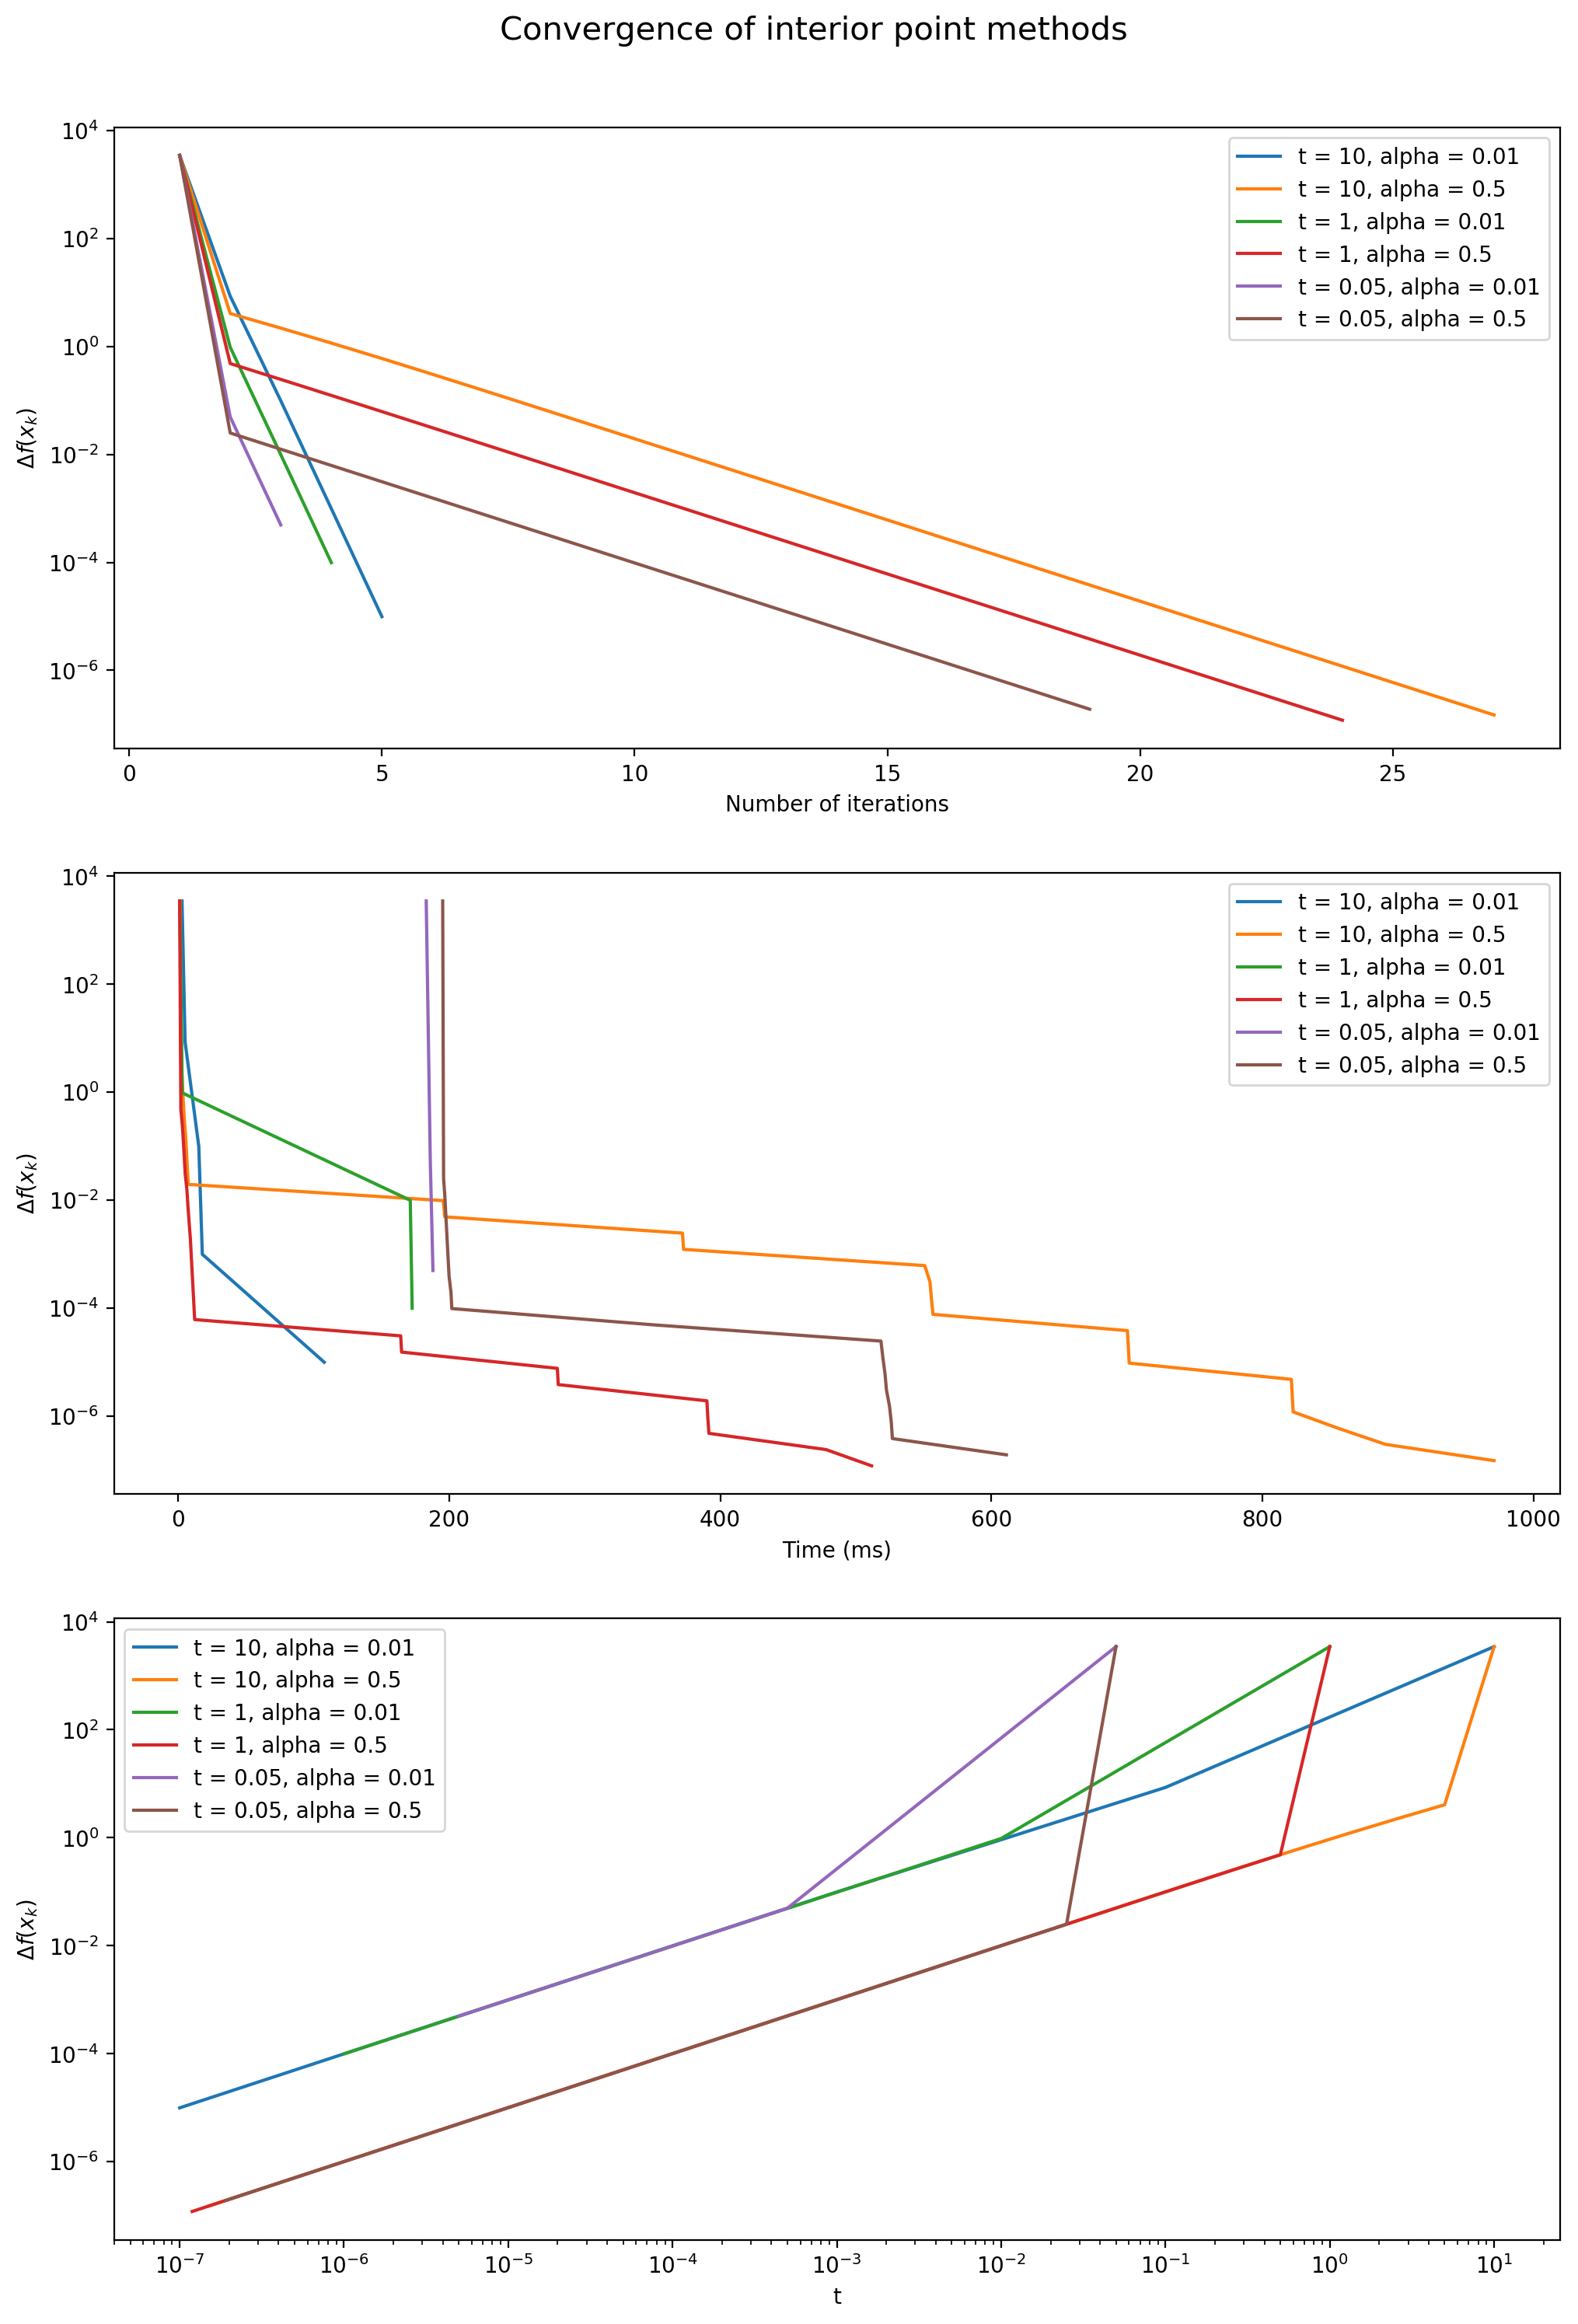

In [18]:
compare(f_stoch,gradf_stoch,hessf_stoch,x0, 10**(-7))

In [19]:
import scipy.optimize as opt

In [20]:
opt.minimize(f_stoch, x0, jac=gradf_stoch, constraints=({"type": "ineq", "fun": lambda x: -np.dot(c, x)}))

     fun: 63.54768784065574
     jac: array([59.81820746, 41.50927081, 51.79472177, 42.08638036, 26.64970657])
 message: 'Optimization terminated successfully.'
    nfev: 18
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.51381303, -0.06361108,  1.26144011, -1.39724401, -1.29929296])

In [21]:
result = interior_point(f_stoch,gradf_stoch,hessf_stoch,x0,10,0.01, 10**(-10))
result['x']

array([ 0.5138131 , -0.06361094,  1.26143917, -1.39724357, -1.29929223])

In [22]:
x, func = solve_wc(x0,10,0.01, 10**(-10))

Values: [59.00646578805022, 69.40754095075613]


In [23]:
x

array([ 0.44322838,  0.02310338,  1.08168304, -1.21455038, -1.21507701])